# Content
- Testing the difference between two means of **independent samples**
    - Using z test
    - Using t test
- Testing the difference between two means of **dependent samples** using t test
- Testing the difference between two proportions
- Testing the difference between two variances and standard deviations

# Overview
Hypothesis testing is used to compare a sample statistic to a population parameter (e.g. H0: μ = 82)

Here we want to compare 2 sample statistics (e.g. H0: μ1 = μ2).
It is very useful to for example compare the wage of workers between 2 factories.

One question to answer is whether the 2 samples are dependent or independent (i.e. is there a relationship between the subject of each sample?)

In [1]:
# Imports
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import pylab

In [2]:
# Generic functions

# Same as is chap. 8
def preferred_rounding(v, decimals=2):
    return str(round(v, decimals))

# Same as is chap. 8
def display_probability_density_chart(
    cv_left=None,
    cv_right=None,
    test_value=None,
):
    r'''
    Display probability density chart.
    '''  
    fig, ax = plt.subplots(1, 1, figsize=(11, 5))
    
    # Standard normal distribution curve
    x = np.linspace(
        stats.norm.ppf(0.001),
        stats.norm.ppf(0.999), 
        100
    )
    curve = stats.norm.pdf(x)
        
    ax.plot(
        x, 
        curve,
        'r-', 
        color='#000000',
        lw=3, 
        alpha=0.8,
        label='Standard normal distribution curve'
    )
    
    # Critical region(s) in chart
    if cv_left:
        critical_region_left = np.linspace(-3.1, cv_left, 100)
        ax.fill_between(
            critical_region_left, 
            stats.norm.pdf(critical_region_left), 
            color='#f4c242', 
            alpha=0.5,
        )
        critical_value_left = np.linspace(cv_left-0.01, cv_left+0.01, 100)
        ax.fill_between(
            critical_value_left, 
            stats.norm.pdf(critical_value_left), 
            color='#f4c242', 
            alpha=1, 
            label='C.V. = ' + preferred_rounding(cv_left)
        )
        
    if cv_right:
        critical_region_right = np.linspace(cv_right, 3.1, 100)
        critical_value_right = np.linspace(cv_right-0.01, cv_right+0.01, 100)
        ax.fill_between(
            critical_value_right, 
            stats.norm.pdf(critical_value_right), 
            color='#f4c242', 
            alpha=1, 
            label='C.V. = ' + preferred_rounding(cv_right)
        )
        ax.fill_between(
            critical_region_right, 
            stats.norm.pdf(critical_region_right), 
            color='#f4c242', 
            alpha=0.5,
        )
       
    # Test value
    if test_value:
        ax.axvline(
            x=test_value, 
            linewidth=1.5, 
            color='#ff6666',
        )
        ax.text(
            x=test_value+.1, 
            y=0.2, 
            s='test value =' + preferred_rounding(test_value), 
            rotation=90,
        )
        
    ax.legend()
    plt.show()
    

# Same as is chap. 8
def get_zscore_from_probability(
    p_left=None, # probability left side of target range (if any)
    p_right=None, # probability right side of target range (if any)    
):
    r'''
    Calculate z-score from table (with ppf).
    '''
    test_value = 0
    if p_left and not p_right:
        test_value = stats.norm.ppf(p_left)
        
    elif p_right and not p_left:
        test_value = 1 - stats.norm.ppf(p_right)
    
    elif p_left and p_right:
        test_value_left = stats.norm.ppf(p_left)
        test_value_right = stats.norm.ppf(p_right)
        test_value = test_value_right - test_value_left
    
    return test_value


# Same as is chap. 8
def get_tscore_from_probability(
    p_left=None, # probability left side of target range (if any)
    p_right=None, # probability right side of target range (if any)
    df=0,
):
    r'''
    Calculate t-score from table (with ppf).
    '''
    test_value = 0
    if p_left and not p_right:
        test_value = stats.t.ppf(p_left, df)
        
    elif p_right and not p_left:
        test_value = 1 - stats.t.ppf(p_right, df)
    
    elif p_left and p_right:
        test_value_left = stats.t.ppf(p_left, df)
        test_value_right = stats.t.ppf(p_right, df)
        test_value = test_value_right - test_value_left
    
    return test_value

# Testing difference between 2 means

## Using z test

### Example

H0: μ1 = μ2 => μ1 - μ2 = 0

H1: μ1 ≠ μ2 => μ1 - μ2 ≠ 0

μ1 = mean wage workers factory A
μ2 = mean wage workers factory B

### Assumptions
1. Both samples are randomly selected
2. Samples are independent from each other
3. **STD of both populations are known** (this is unusual in practice)
4. Both sample size >= 30 or both samples follow a normal distribution

### Formulas

The z test is based on the format: test value = [(observed value) - (expected value)]/(standard error)

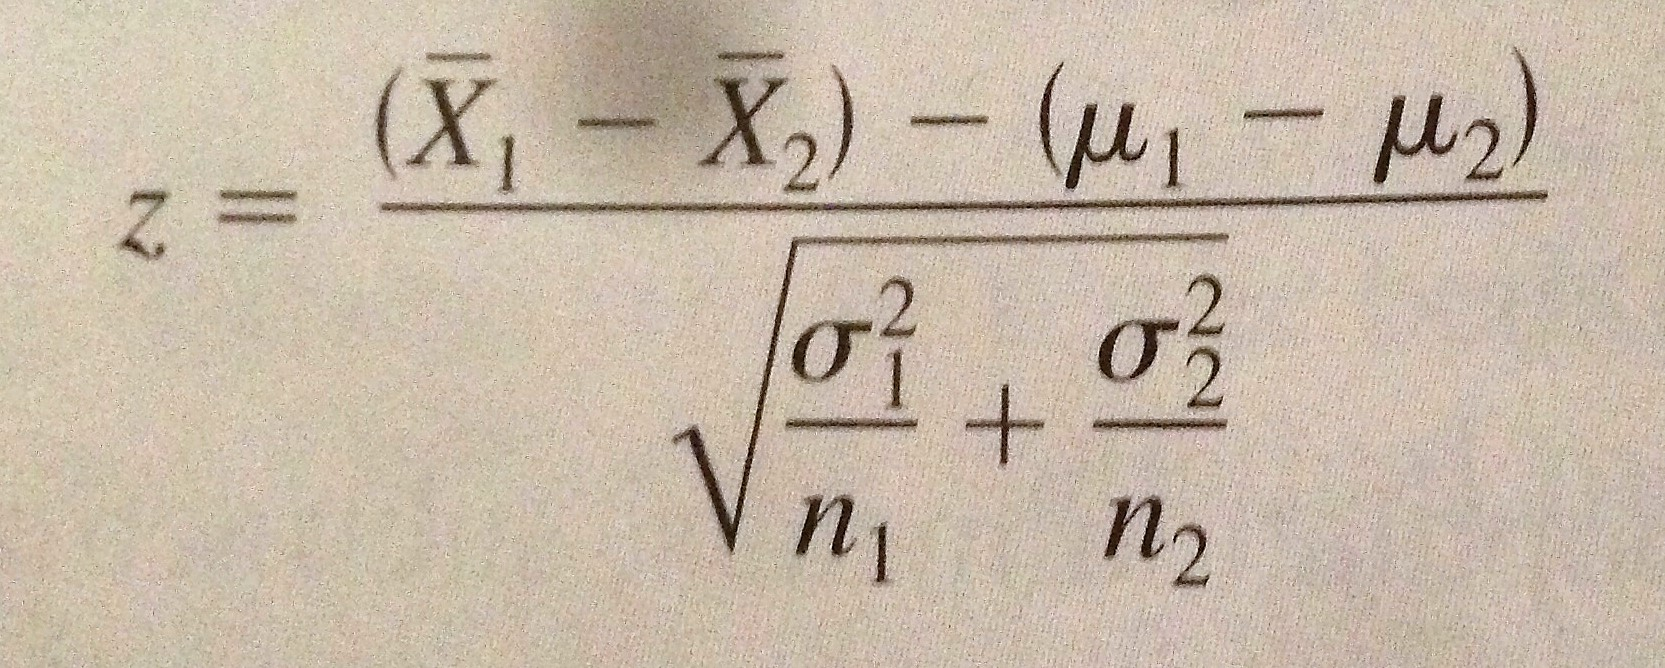

If we hypothesize a difference of 0, then we reject H0 only if CI does NOT include 0.

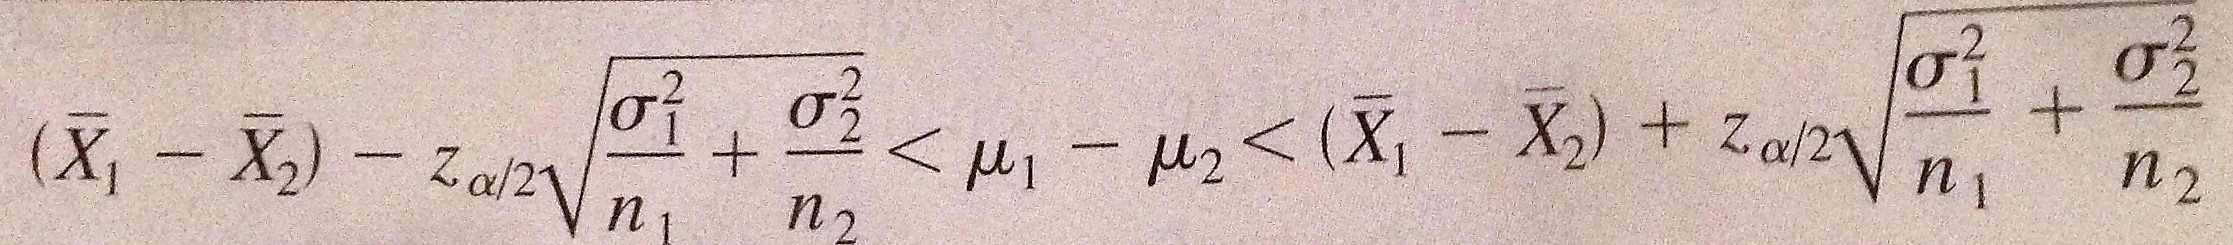

In [28]:
def compute_difference_between_two_means_independent(
    dataset1=None,
    n1=None,
    sample_mean1=None,
    sample_std1=None,
    population_std1=None,
    
    dataset2=None,
    n2=None,
    sample_mean2=None,
    sample_std2=None,
    population_std2=None,
    
    expected_value=0,
    tail='two-tailed',
    significance_level=.05,
    ddof=1, # delta degree of freedome (default is 1)
    show_chart=False,
):
    r"""
    Conduct a statistical hypothesis test comparing two sample means. 
    Works for σ known and unknown.
    The claim is the alternative hypothesis and the problem statement has to be formulated as such.
    """
    
    # Conditions to stop
    assert tail in ('two-tailed', 'right-tailed', 'left-tailed')
    
    if dataset1 and dataset2:
        dataset_np1 = np.array(dataset1)
        n1 = len(dataset_np1) # sample size          
        sample_mean1 = np.mean(dataset_np1) # sample mean        
        sample_std1 = np.std(dataset_np1, ddof=ddof) # sample STD
        
        dataset_np2 = np.array(dataset2)
        n2 = len(dataset_np2) # sample size          
        sample_mean2 = np.mean(dataset_np2) # sample mean        
        sample_std2 = np.std(dataset_np2, ddof=ddof) # sample STD
    
    if population_std1 and population_std2: # When σ1 and σ2 known  
        population_variance1 = np.power(population_std1, 2) # population variance
        population_variance2 = np.power(population_std2, 2) # population variance
    elif sample_std1 and sample_std2:
        sample_variance1 = np.power(sample_std1, 2) # sample variance
        sample_variance2 = np.power(sample_std2, 2) # sample variance
        
    
    df1 = n1-ddof # degree of freedom
    df2 = n2-ddof # degree of freedom
    df = min(df1, df2)
    
    # Parameters and statistics
    print('Parameters and statistics')    
    print('-------------------------')
    print('Sample mean 1 (X1) =', sample_mean1)
    print('Sample STD 1 =', sample_std1)        
    print('Sample size 1 =', n1)
    print('Population STD 1 =', population_std1)
    
    print('Sample mean 2 (X2) =', sample_mean2)
    print('Sample STD 2 =', sample_std2)        
    print('Sample size 2 =', n2)
    print('Population STD 2 =', population_std2)
    
    print('Significance level =', significance_level)
    print('Test type =', tail)
    
    # 1. Hypothesis
    print()
    print('1. Hypothesis')
    if tail == 'two-tailed':
        operator = '≠'
        operator_label = 'different from'
    elif tail == 'right-tailed':
        operator = '>'
        operator_label = 'more than'
    elif tail == 'left-tailed':
        operator = '<'
        operator_label = 'less than'
    
    # Statement
    h0 = 'H0: μ1 = μ2; H0: μ1-μ2 = 0'
    h1 = 'H1: μ1 {operator} μ2; H1: μ1-μ2 {operator} 0'.format(operator=operator)   
    print(h0)
    print(h1, '(claim)')
    
    # 2. Critical value(s)
    print()
    print('2. Critical value(s)')
    cv_left, cv_right = None, None
    tailed_alpha = significance_level
    
    if population_std1 and population_std2: # When σ1 and σ2 known
        if tail == 'two-tailed':
            tailed_alpha = significance_level/2
            cv_right = abs(get_zscore_from_probability(p_left=tailed_alpha))
            cv_left = -cv_right
            print('C.V. =', '±' + preferred_rounding(cv_right), '(two-tailed)')
        elif tail == 'right-tailed':
            cv_right= get_zscore_from_probability(p_right=tailed_alpha)
            print('C.V. =', preferred_rounding(cv_right), '(right-tailed)')
        elif tail == 'left-tailed':
            cv_left = get_zscore_from_probability(p_left=tailed_alpha)
            print('C.V. =', preferred_rounding(cv_left), '(left-tailed)')
            
    else: # When σ1 and σ2 unknown
        if tail == 'two-tailed':
            tailed_alpha = significance_level/2
            cv_right = abs(get_tscore_from_probability(p_left=tailed_alpha, df=df))
            cv_left = -cv_right
            print('C.V. =', '±' + preferred_rounding(cv_right), '(two-tailed)')
        elif tail == 'right-tailed':
            cv_right= get_tscore_from_probability(p_right=tailed_alpha, df=df)
            print('C.V. =', preferred_rounding(cv_right), '(right-tailed)')
        elif tail == 'left-tailed':
            cv_left = get_tscore_from_probability(p_left=tailed_alpha, df=df)
            print('C.V. =', preferred_rounding(cv_left), '(left-tailed)')
    
    # 3. Test value, P-value and chart
    print()
    print('3. Test value, P-value and chart')
    
    # Hypothesis test for comparing two means
    if population_std1 and population_std2: # When σ1 and σ2 known
        print('Test type: z test')
        standard_error = np.sqrt((population_variance1/n1) + (population_variance2/n2))
        test_value = ((sample_mean1-sample_mean2)-(expected_value))/standard_error
    else: # When σ1 and σ2 unknown 
        print('Test type: t test')
        standard_error = np.sqrt((sample_variance1/n1) + (sample_variance2/n2))
        observed_value = sample_mean1 - sample_mean2
        test_value = (observed_value-expected_value)/standard_error

    # Calculate P-value
    if population_std1 and population_std2: # When σ1 and σ2 known
        p_value = stats.norm.sf(abs(test_value))     
    else: # When σ1 and σ2 known
        p_value = stats.t.sf(abs(test_value), df=df) 
    if tail == 'two-tailed':   
        p_value = p_value*2 
    print('test value = ', preferred_rounding(test_value))
    print('P-value = ', preferred_rounding(p_value, 4))
    
    # Chart
    if show_chart:
        display_probability_density_chart(
            cv_left=cv_left,
            cv_right=cv_right,
            test_value=test_value,
        )
        
    # 4a. Result and decision (traditional method)
    print()
    print('4a. Result and decision (traditional method)')
    
    decision_statement = 'reject'
    evidence_statement = 'enough evidence'
    if cv_left and cv_right:
        if (test_value < 0 and cv_left < test_value) or (test_value > 0 and cv_right > test_value):
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_left:
        if cv_left < test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_right:
        if cv_right > test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
            
    print('The decision is to', decision_statement, 'the null hypothesis.')
    
    claim = 'μ1-u2 is {} {}'.format(operator_label, str(expected_value))
    print('There is', evidence_statement, 'to support the claim that', claim, 
          'with a significance level of', str(significance_level) + '.')
  
    print()
    if decision_statement == 'reject':
        print('Although the difference between sample mean and population mean is said to be significant, there is a risk of a type I error',
              '(rejecting H0 althought it is true).')
        print('In this case, the probability of a type I error is', '{:0.0f}%'.format(significance_level*100) + '.')
        print('You could try to reduce the significance level to decrease the probability of a type I error.')
        
    elif decision_statement == 'not reject':
        print('Although the difference between sample mean and population mean is not significant, there is a risk of a type II error',
              '(not rejecting H0 althought it is false).')
        print('You could try to increase the significance level to decrease the probability of a type II error.', 
              'However, this would increase the probability of a type I error')
        
    # 4b. Result and decision (P-value method)
    print()
    print('4b. Result and decision (P-value method)')
    print('P-value = ', p_value)
    print('Tailed alpha = ', tailed_alpha)
    if p_value <= tailed_alpha:
        decision_statement_p_value_method = 'reject'
        print('P-value ≤ ∝, therefore we reject H0.')
    else:
        decision_statement_p_value_method = 'not reject'
        print('P-value > ∝, therefore we do NOT reject H0.')  
        
    # 5. Summary
    print()
    print('5. Summary')
    if decision_statement == decision_statement_p_value_method:
        print('The traditional method and P-value method support the same conclusion.')
    else:
        print('The traditional method and P-value method do NOT support the same conclusion.')

Parameters and statistics
-------------------------
Sample mean 1 (X1) = 88.42
Sample STD 1 = None
Sample size 1 = 50
Population STD 1 = 5.62
Sample mean 2 (X2) = 80.61
Sample STD 2 = None
Sample size 2 = 50
Population STD 2 = 4.83
Significance level = 0.05
Test type = two-tailed

1. Hypothesis
H0: μ1 = μ2; H0: μ1-μ2 = 0
H1: μ1 ≠ μ2; H1: μ1-μ2 ≠ 0 (claim)

2. Critical value(s)
C.V. = ±1.96 (two-tailed)

3. Test value, P-value and chart
Test type: z test
test value =  7.45
P-value =  0.0


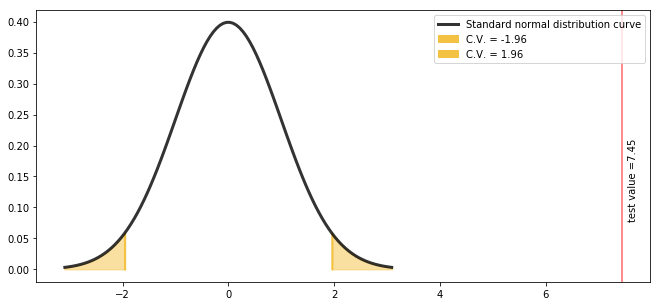


4a. Result and decision (traditional method)
The decision is to reject the null hypothesis.
There is enough evidence to support the claim that μ1-u2 is different from 0 with a significance level of 0.05.

Although the difference between sample mean and population mean is said to be significant, there is a risk of a type I error (rejecting H0 althought it is true).
In this case, the probability of a type I error is 5%.
You could try to reduce the significance level to decrease the probability of a type I error.

4b. Result and decision (P-value method)
P-value =  9.164412462954092e-14
Tailed alpha =  0.025
P-value ≤ ∝, therefore we reject H0.

5. Summary
The traditional method and P-value method support the same conclusion.


In [30]:
# Survey found that average hotel room rate in London is $88.42 and HK is $80.61.
# Data obtained from 2 samples of 50 hotels each and std of populations are $5.62 and $4.83.
# At alpha = 0.05, can it be concluded that there is significant difference between rates?

n = 50
compute_difference_between_two_means_independent(
    dataset1=None,
    n1=n,
    sample_mean1=88.42,
    sample_std1=None,
    population_std1=5.62,
    
    dataset2=None,
    n2=n,
    sample_mean2=80.61,
    sample_std2=None,
    population_std2=4.83,
    
    expected_value=0,
    tail='two-tailed',
    significance_level=.05,
    ddof=1,
    show_chart=True,
)

Parameters and statistics
-------------------------
Sample mean 1 (X1) = 8.56
Sample STD 1 = 3.258646269573315
Sample size 1 = 50
Population STD 1 = 3.3
Sample mean 2 (X2) = 7.94
Sample STD 2 = 3.2664653554518757
Sample size 2 = 50
Population STD 2 = 3.3
Significance level = 0.1
Test type = right-tailed

1. Hypothesis
H0: μ1 = μ2; H0: μ1-μ2 = 0
H1: μ1 > μ2; H1: μ1-μ2 > 0 (claim)

2. Critical value(s)
C.V. = 2.28 (right-tailed)

3. Test value, P-value and chart
Test type: z test
test value =  0.94
P-value =  0.1738


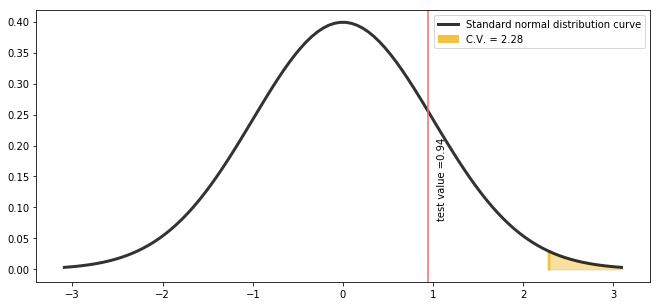


4a. Result and decision (traditional method)
The decision is to not reject the null hypothesis.
There is not enough evidence to support the claim that μ1-u2 is more than 0 with a significance level of 0.1.

Although the difference between sample mean and population mean is not significant, there is a risk of a type II error (not rejecting H0 althought it is false).
You could try to increase the significance level to decrease the probability of a type II error. However, this would increase the probability of a type I error

4b. Result and decision (P-value method)
P-value =  0.1737642617616869
Tailed alpha =  0.1
P-value > ∝, therefore we do NOT reject H0.

5. Summary
The traditional method and P-value method support the same conclusion.


In [31]:
# Check if average number of sport offerings for male and female is different.
# At alpha = 0.10, is there enough evidence to support the claim?
# Population STD 1 and 2 = 3.3.

sport_list_male = [
    6, 11, 11, 8, 15,
    6, 14, 8, 12, 18,
    6, 9, 5, 6, 9,
    6, 9, 18, 7, 6,
    15, 6, 11, 5, 5,
    9, 9, 5, 5, 8,
    8, 9, 6, 11, 6,
    9, 5, 11, 5, 8,
    7, 7, 5, 10, 7,
    10, 7, 10, 8, 11,
]
sport_list_female = [
    6, 8, 11, 13, 8,
    7, 5, 13, 14, 6,
    6, 5, 5, 7, 6,
    10, 7, 6, 5 , 5,
    16, 10, 7, 8, 5,
    7, 5, 5, 6, 5,
    9, 18, 13, 7, 10,
    7, 8, 5, 7, 6,
    11, 4, 6, 8, 7,
    14, 12, 5, 8, 5,
]

compute_difference_between_two_means_independent(
    dataset1=sport_list_male,
#     n1=50,
#     sample_mean1=8.6,
    sample_std1=None,
    population_std1=3.3,
    
    dataset2=sport_list_female,
#     n2=50,
#     sample_mean2=7.9,
    sample_std2=None,
    population_std2=3.3,
    
    expected_value=0,
    tail='right-tailed',
    significance_level=.10,
    ddof=1,
    show_chart=True,
)

### Confidence interval calculation

In [33]:
# Code from chapter 8 (adjusted for new formula)

def compute_confidence_interval_for_difference_between_two_means_independent(
    dataset1=None,
    n1=None,
    sample_mean1=None,
    sample_std1=None,
    population_std1=None,
    
    dataset2=None,
    n2=None,
    sample_mean2=None,
    sample_std2=None,
    population_std2=None,
    
    expected_value=0,
    ddof=1,
    confidence_level=0.95,
):
    r"""
    Compute the confidence interval of the difference between 2 means. 
    Works for σ known and unknown.
    """
    
    if dataset1 and dataset2:
        dataset_np1 = np.array(dataset1)
        n1 = len(dataset_np1) # sample size          
        sample_mean1 = np.mean(dataset_np1) # sample mean        
        sample_std1 = np.std(dataset_np1, ddof=ddof) # sample STD
        
        dataset_np2 = np.array(dataset2)
        n2 = len(dataset_np2) # sample size          
        sample_mean2 = np.mean(dataset_np2) # sample mean        
        sample_std2 = np.std(dataset_np2, ddof=ddof) # sample STD
    
    if population_std1 and population_std2: # When σ1 and σ2 known  
        population_variance1 = np.power(population_std1, 2) # population variance
        population_variance2 = np.power(population_std2, 2) # population variance     
    elif sample_std1 and sample_std2:
        sample_variance1 = np.power(sample_std1, 2) # sample variance
        sample_variance2 = np.power(sample_std2, 2) # sample variance
        
    df1 = n1-ddof # degree of freedom
    df2 = n2-ddof # degree of freedom
    df = min(df1, df2)
    
    ci_dict = dict() # confidence interval dictionary (output)
    
    alpha_half = (1 - confidence_level) / 2
    if population_std1 and population_std2: # When σ known
        margin_of_error = np.sqrt(population_variance1/n1 + population_variance2/n2)
        z_value_alpha_half = stats.norm.ppf(1 - alpha_half)
        sample_mean_difference = sample_mean1 - sample_mean2
        h = z_value_alpha_half * margin_of_error

    else: # When σ unknown                 
        margin_of_error = np.sqrt(sample_variance1/n1 + sample_variance2/n2)
        t_value_alpha_half = stats.t.ppf(1 - alpha_half, df=df)
        sample_mean_difference = sample_mean1 - sample_mean2
        h = t_value_alpha_half * margin_of_error

    # Result
    ci_left = sample_mean_difference - h
    ci_right = sample_mean_difference + h
    ci_dict[confidence_level] = {
        'ci_left': ci_left,
        'ci_right': ci_right,
    }
    print('Confidence interval: {} < μ1-μ2 < {}'.format(preferred_rounding(ci_left, 2), preferred_rounding(ci_right, 2)))
    
    print('Expected value:', expected_value)
    if ci_left < expected_value < ci_right:
        print('The confidence interval contains the expected value, therefore we do NOT reject H0.')
    else:
        print('The confidence interval does not contains the expected value, therefore we reject H0.')
          
    return ci_dict

In [35]:
# Survey found that average hotel room rate in London is $88.42 and HK is $80.61.
# Data obtained from 2 samples of 50 hotels each and std of populations are $5.62 and $4.83.
# At alpha = 0.05, can it be concluded that there is significant difference between rates?
# Same exercise as above, but with CI method.

n = 50
ci = compute_confidence_interval_for_difference_between_two_means_independent(
    dataset1=None,
    n1=n,
    sample_mean1=88.42,
    sample_std1=None,
    population_std1=5.62,
    
    dataset2=None,
    n2=n,
    sample_mean2=80.61,
    sample_std2=None,
    population_std2=4.83,
    
    expected_value=0,
    confidence_level=0.95,
    ddof=1,
)

Confidence interval: 5.76 < μ1-μ2 < 9.86
Expected value: 0
The confidence interval does not contains the expected value, therefore we reject H0.


## Using t test

Use when the population standard deviations are not known.
**This has a much heigher practical relevance.**

### Assumptions

- Both samples are randomly selected
- Samples are independent from each other
- Both sample size >= 30 or both samples follow a normal distribution
- STD of both populations are unknown

### Formulas

**Test value**

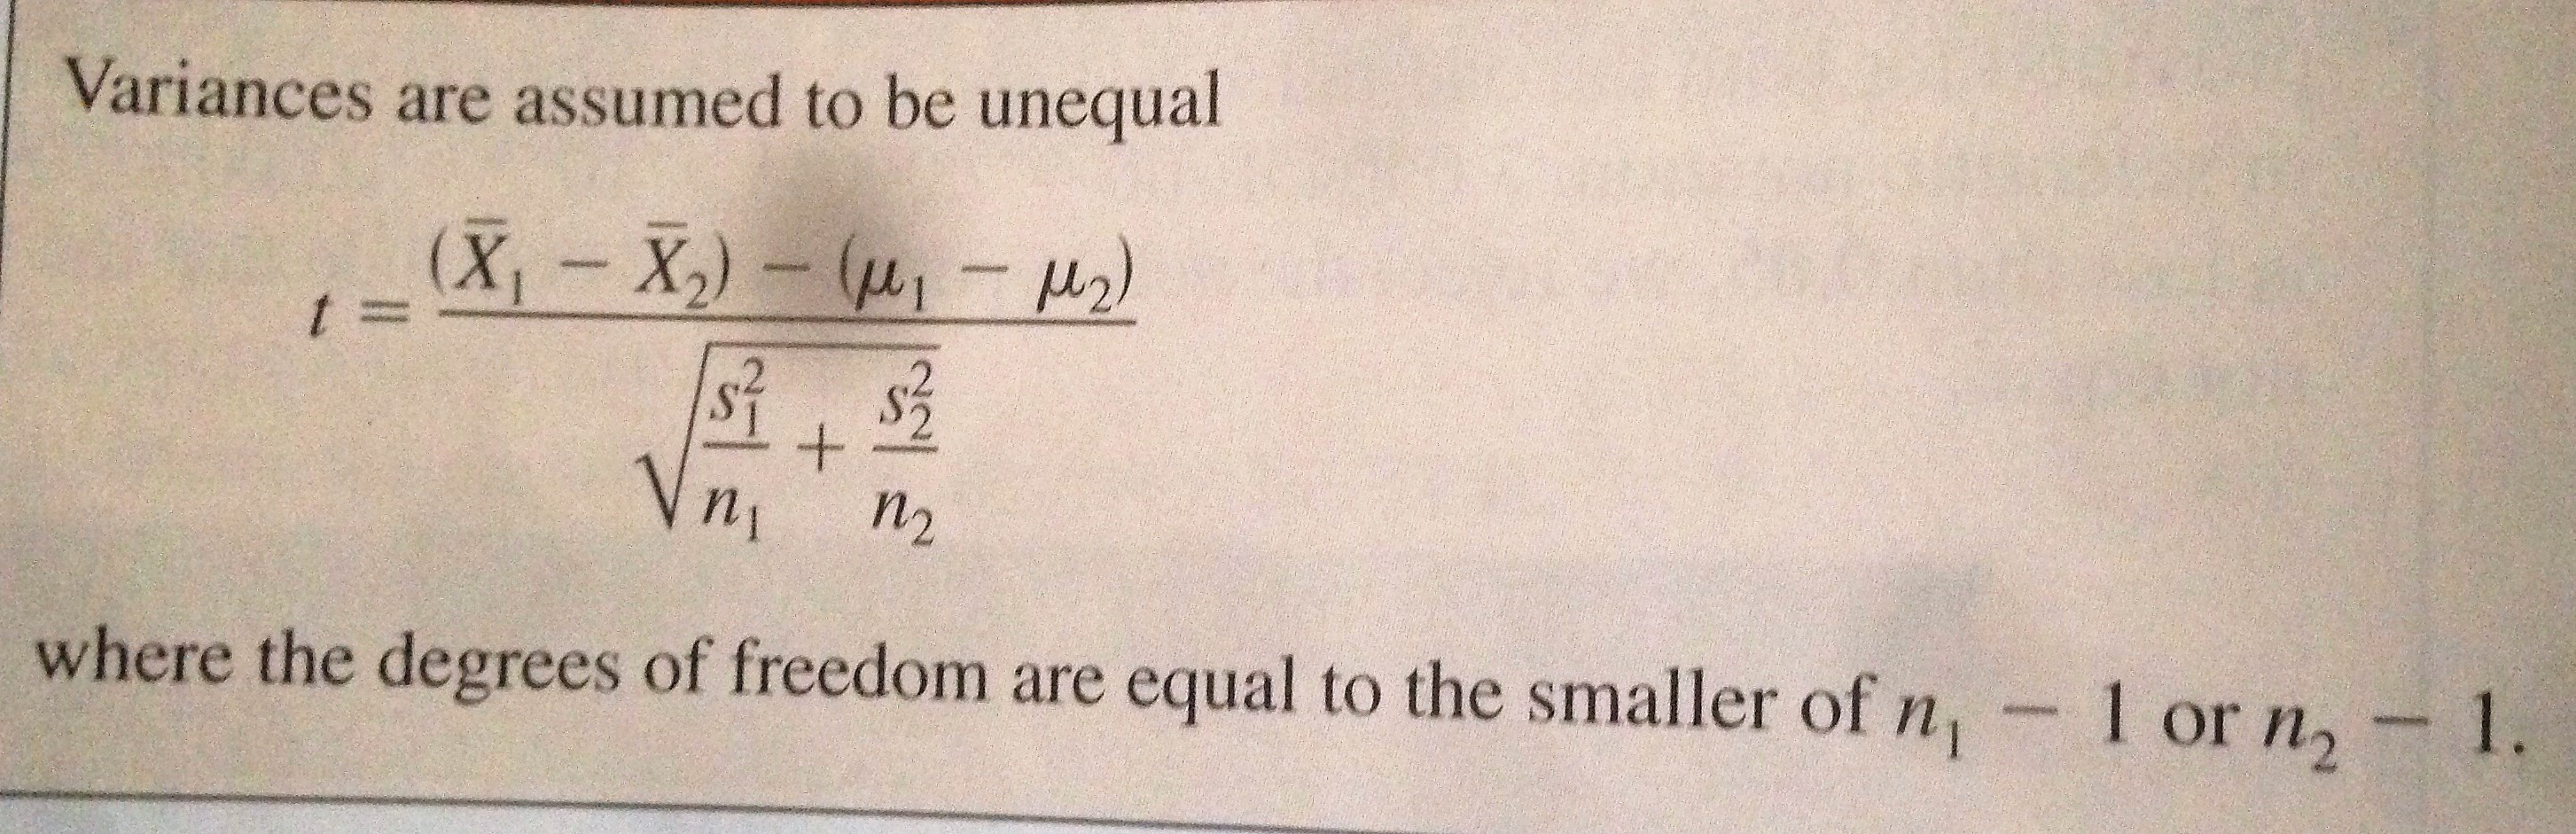

**Confidence interval**

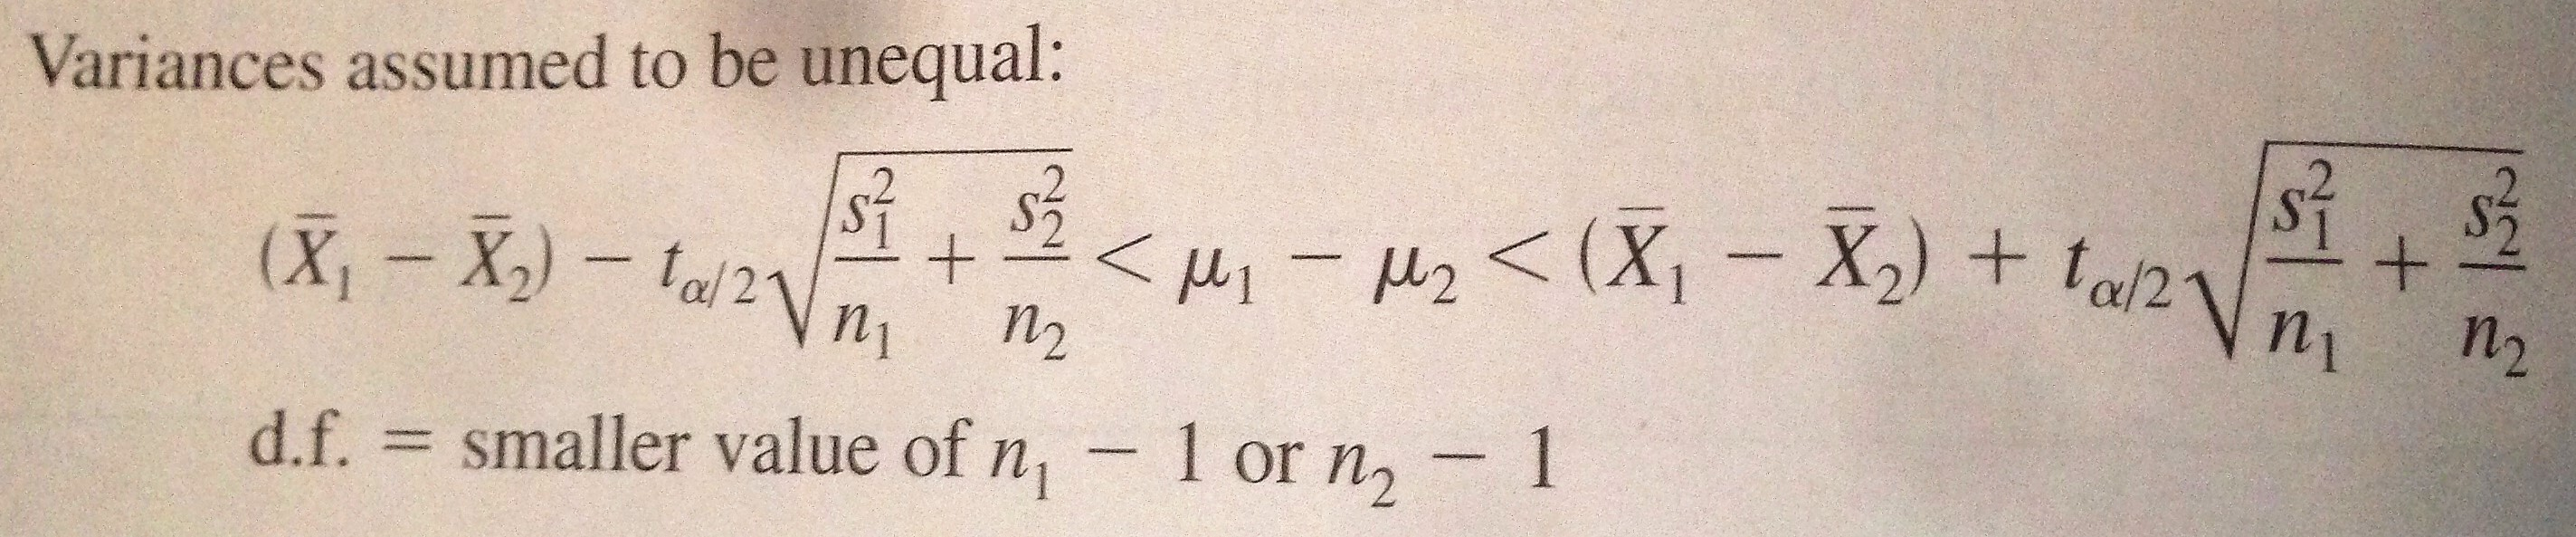

### Examples

Parameters and statistics
-------------------------
Sample mean 1 (X1) = 191
Sample STD 1 = 38
Sample size 1 = 8
Population STD 1 = None
Sample mean 2 (X2) = 199
Sample STD 2 = 12
Sample size 2 = 10
Population STD 2 = None
Significance level = 0.05
Test type = two-tailed

1. Hypothesis
H0: μ1 = μ2; H0: μ1-μ2 = 0
H1: μ1 ≠ μ2; H1: μ1-μ2 ≠ 0 (claim)

2. Critical value(s)
C.V. = ±2.36 (two-tailed)

3. Test value, P-value and chart
Test type: t test
test value =  -0.57
P-value =  0.5845


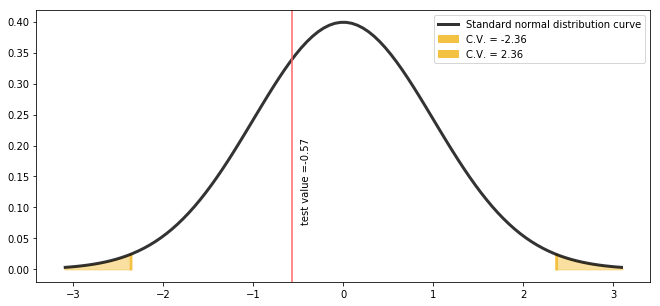


4a. Result and decision (traditional method)
The decision is to not reject the null hypothesis.
There is not enough evidence to support the claim that μ1-u2 is different from 0 with a significance level of 0.05.

Although the difference between sample mean and population mean is not significant, there is a risk of a type II error (not rejecting H0 althought it is false).
You could try to increase the significance level to decrease the probability of a type II error. However, this would increase the probability of a type I error

4b. Result and decision (P-value method)
P-value =  0.584548025208316
Tailed alpha =  0.025
P-value > ∝, therefore we do NOT reject H0.

5. Summary
The traditional method and P-value method support the same conclusion.


In [20]:
# Average size of farm in country A is 191 km² with STD of 38 km² and n of 8.
# Average size of farm in country B is 199 km² with STD of 12 km² and n of 10.
# Can it be concluded at alpha = 0.05 that average size of farms in 2 countries is different?
# Populations are normally distributed.

compute_difference_between_two_means_independent(
    dataset1=None,
    n1=8,
    sample_mean1=191,
    sample_std1=38,
    population_std1=None,
    
    dataset2=None,
    n2=10,
    sample_mean2=199,
    sample_std2=12,
    population_std2=None,
    
    expected_value=0,
    tail='two-tailed',
    significance_level=.05,
    sample_relationship='independent',
    ddof=1, # delta degree of freedome (default is 1)
    show_chart=True,
)

In [34]:
# Average size of farm in country A is 191 km² with STD of 38 km² and n of 8.
# Average size of farm in country B is 199 km² with STD of 12 km² and n of 10.
# Can it be concluded at alpha = 0.05 that average size of farms in 2 countries is different?
# Populations are normally distributed.

ci = compute_confidence_interval_for_difference_between_two_means_independent(
    dataset1=None,
    n1=8,
    sample_mean1=191,
    sample_std1=38,
    population_std1=None,
    
    dataset2=None,
    n2=10,
    sample_mean2=199,
    sample_std2=12,
    population_std2=None,
    
    expected_value=0,
    ddof=1,
    confidence_level=0.95,
)

Confidence interval: -41.01 < μ1-μ2 < 25.01
Expected value: 0
The confidence interval contains the expected value, therefore we do NOT reject H0.


# Testing the difference between two means of dependent samples using t test

Here we use a **special t test**.

## Application
Samples are considered to be dependent when:
- same subjects are used in pre-post situation (e.g. students perform better the second time they take the GMAT)
- subjects are pre-classified before running the statistical test (e.g. students paired according to IQ and then 1 student assigned to group with computer and the other to group with paper)

## Assumptions


- Both samples are randomly selected
- Both samples are **dependent**
- Both sample sizes >= 30 or both samples follow a normal distribution


## Formula

**Test value**

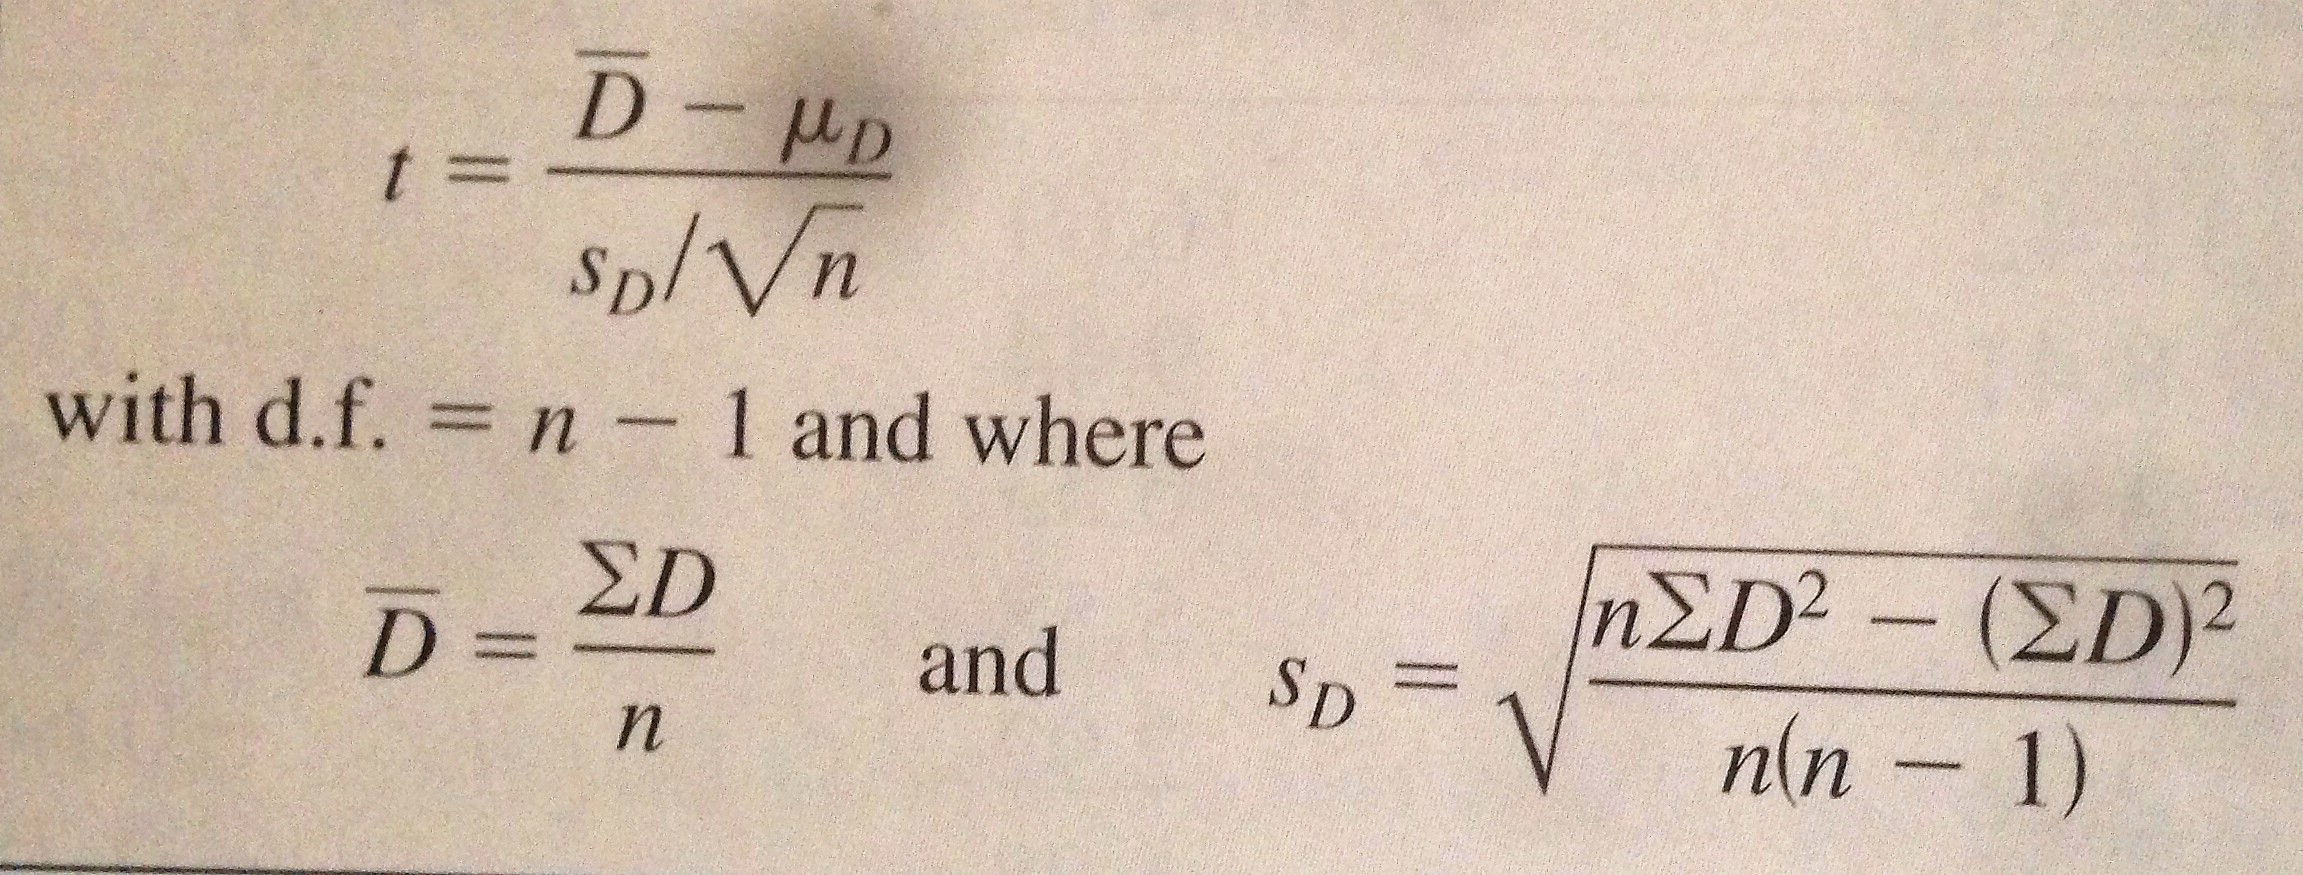

**Confidence interval**

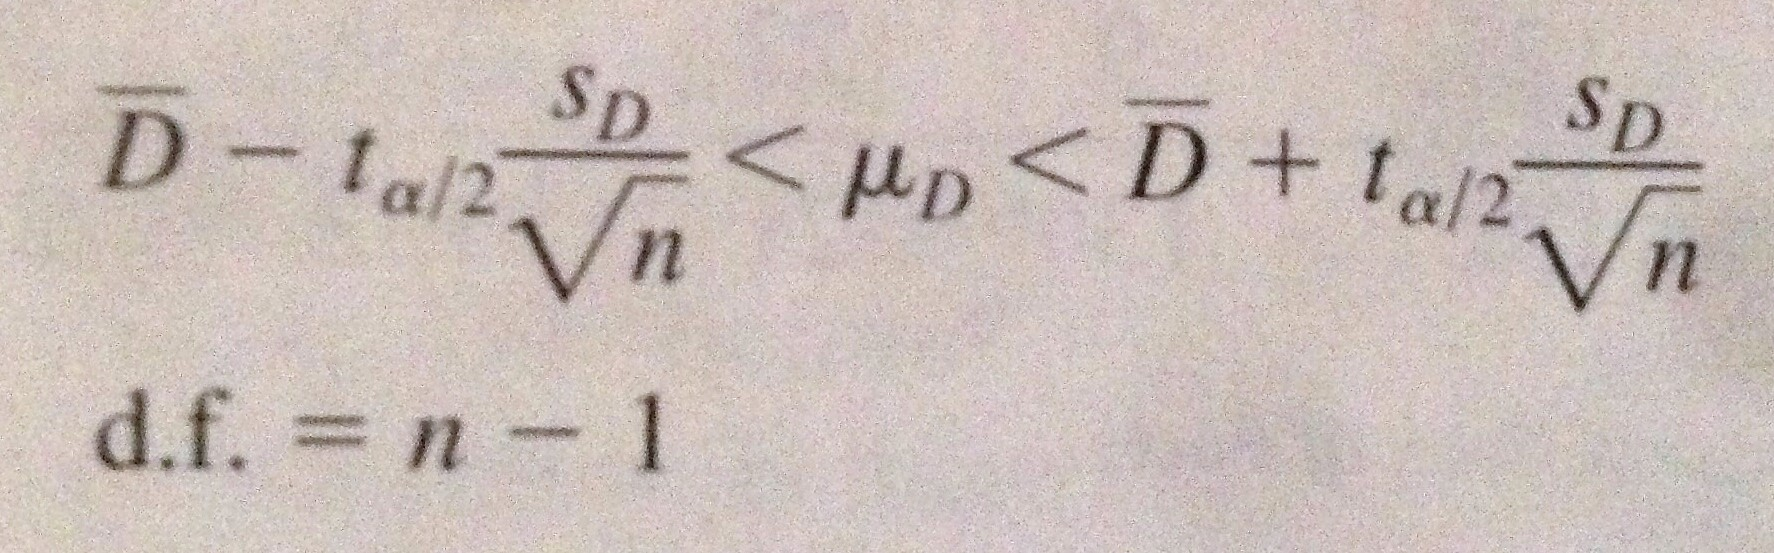

## Implementation

In [49]:
def compute_difference_between_two_means_dependent(
    dataset1=None,    
    dataset2=None,    
    expected_value=0,
    tail='two-tailed',
    significance_level=.05,
    ddof=1, # delta degree of freedome (default is 1)
    show_chart=False,
):
    r"""
    Conduct a statistical hypothesis test comparing the means of two samples that are dependent. 
    The claim is the alternative hypothesis and the problem statement has to be formulated as such.
    Both datasets must have the same n.
    """
    
    # Conditions to stop
    assert tail in ('two-tailed', 'right-tailed', 'left-tailed')
    assert dataset1 and dataset2
    assert len(dataset1) and len(dataset2)
    
    dataset_np1 = np.array(dataset1)
    n1 = len(dataset_np1) # sample size          
    sample_mean1 = np.mean(dataset_np1) # sample mean        
    sample_std1 = np.std(dataset_np1, ddof=ddof) # sample STD
    sample_variance1 = np.power(sample_std1, 2) # sample variance

    dataset_np2 = np.array(dataset2)
    n2 = len(dataset_np2) # sample size          
    sample_mean2 = np.mean(dataset_np2) # sample mean        
    sample_std2 = np.std(dataset_np2, ddof=ddof) # sample STD
    sample_variance2 = np.power(sample_std2, 2) # sample variance
        
    n = n1
    df = n-ddof # degree of freedom
    
    # Parameters and statistics
    print('Parameters and statistics')    
    print('-------------------------')
    print('Sample mean 1 (X1) =', sample_mean1)
    print('Sample STD 1 =', sample_std1)        
    print('Sample size 1 =', n1)
    
    print('Sample mean 2 (X2) =', sample_mean2)
    print('Sample STD 2 =', sample_std2)        
    print('Sample size 2 =', n2)
    
    print('Significance level =', significance_level)
    print('Test type =', tail)
    
    # 1. Hypothesis
    print()
    print('1. Hypothesis')
    if tail == 'two-tailed':
        operator = '≠'
        operator_label = 'different from'
    elif tail == 'right-tailed':
        operator = '>'
        operator_label = 'more than'
    elif tail == 'left-tailed':
        operator = '<'
        operator_label = 'less than'
    
    # Statement
    h0 = 'H0: μD = {}'.format(str(expected_value))
    h1 = 'H1: μD {} {}'.format(operator, str(expected_value))   
    print(h0)
    print(h1, '(claim)')
    
    # 2. Critical value(s)
    print()
    print('2. Critical value(s)')
    cv_left, cv_right = None, None
    tailed_alpha = significance_level
   
    if tail == 'two-tailed':
        tailed_alpha = significance_level/2
        cv_right = abs(get_tscore_from_probability(p_left=tailed_alpha, df=df))
        cv_left = -cv_right
        print('C.V. =', '±' + preferred_rounding(cv_right), '(two-tailed)')
    elif tail == 'right-tailed':
        cv_right= get_tscore_from_probability(p_right=tailed_alpha, df=df)
        print('C.V. =', preferred_rounding(cv_right), '(right-tailed)')
    elif tail == 'left-tailed':
        cv_left = get_tscore_from_probability(p_left=tailed_alpha, df=df)
        print('C.V. =', preferred_rounding(cv_left), '(left-tailed)')
    
    # 3. Test value and chart
    print()
    print('3. Test value and chart')
    
    # Hypothesis test for comparing two means
    print('Test type: special t test (for dependent samples)')
    
    D_list, D_square_list = list(), list()
    for l1, l2 in zip(dataset1, dataset2):
        d = l1-l2
        D_list.append(d)
        D_square_list.append(np.power(d, 2))
                               
    D_sum = sum(D_list)
    D_mean = D_sum/n
    D_square_sum = sum(D_square_list)
    SD = np.sqrt((n*D_square_sum-np.power(D_sum, 2))/(n*(n-1)))
    
    standard_error = SD/np.sqrt(n)
    observed_value = D_mean
    test_value = (observed_value-expected_value)/standard_error
    print('D sum =', D_sum)
    print('D mean =', D_mean)
    print('D² sum =', D_square_sum)
    print('SD =', SD)
    print('test value =', test_value)
    
    # Chart
    if show_chart:
        display_probability_density_chart(
            cv_left=cv_left,
            cv_right=cv_right,
            test_value=test_value,
        )
        
    # 4. Result and decision (traditional method)
    print()
    print('4. Result and decision (traditional method)')
    
    decision_statement = 'reject'
    evidence_statement = 'enough evidence'
    if cv_left and cv_right:
        if (test_value < 0 and cv_left < test_value) or (test_value > 0 and cv_right > test_value):
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_left:
        if cv_left < test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_right:
        if cv_right > test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
            
    print('The decision is to', decision_statement, 'the null hypothesis.')
    
    claim = 'μD is {} {}'.format(operator_label, str(expected_value))
    print('There is', evidence_statement, 'to support the claim that', claim, 
          'with a significance level of', str(significance_level) + '.')
  
    print()
    if decision_statement == 'reject':
        print('Although the difference between sample mean and population mean is said to be significant, there is a risk of a type I error',
              '(rejecting H0 althought it is true).')
        print('In this case, the probability of a type I error is', '{:0.0f}%'.format(significance_level*100) + '.')
        print('You could try to reduce the significance level to decrease the probability of a type I error.')
        
    elif decision_statement == 'not reject':
        print('Although the difference between sample mean and population mean is not significant, there is a risk of a type II error',
              '(not rejecting H0 althought it is false).')
        print('You could try to increase the significance level to decrease the probability of a type II error.', 
              'However, this would increase the probability of a type I error')

In [57]:
# Code from chapter 8 (adjusted for new formula)

def compute_confidence_interval_for_difference_between_two_means_dependent(
    dataset1=None,    
    dataset2=None,    
    expected_value=0,
    confidence_level=0.95,
    ddof=1, # delta degree of freedome (default is 1)
):
    r"""
    Compute the confidence interval of the difference between 2 means of dependent samples.
    """
    
    # Conditions to stop
    assert dataset1 and dataset2
    assert len(dataset1) and len(dataset2)
    
    dataset_np1 = np.array(dataset1)
    n1 = len(dataset_np1) # sample size          
    sample_mean1 = np.mean(dataset_np1) # sample mean        
    sample_std1 = np.std(dataset_np1, ddof=ddof) # sample STD
    sample_variance1 = np.power(sample_std1, 2) # sample variance

    dataset_np2 = np.array(dataset2)
    n2 = len(dataset_np2) # sample size          
    sample_mean2 = np.mean(dataset_np2) # sample mean        
    sample_std2 = np.std(dataset_np2, ddof=ddof) # sample STD
    sample_variance2 = np.power(sample_std2, 2) # sample variance
        
    n = n1
    df = n-ddof # degree of freedom
    
    ci_dict = dict() # confidence interval dictionary (output)
    
    # Compute interval
    D_list, D_square_list = list(), list()
    for l1, l2 in zip(dataset1, dataset2):
        d = l1-l2
        D_list.append(d)
        D_square_list.append(np.power(d, 2))
                               
    D_sum = sum(D_list)
    D_mean = D_sum/n
    D_square_sum = sum(D_square_list)
    SD = np.sqrt((n*D_square_sum-np.power(D_sum, 2))/(n*(n-1)))
    
    alpha_half = (1 - confidence_level) / 2               
    margin_of_error = SD/np.sqrt(n)
    t_value_alpha_half = stats.t.ppf(1 - alpha_half, df=df)
    h = t_value_alpha_half * margin_of_error

    # Result
    ci_left = D_mean - h
    ci_right = D_mean + h
    ci_dict[confidence_level] = {
        'ci_left': ci_left,
        'ci_right': ci_right,
    }
    print('Confidence interval: {} < μ1-μ2 < {}'.format(preferred_rounding(ci_left, 2), preferred_rounding(ci_right, 2)))
    
    print('Expected value:', expected_value)
    if ci_left < expected_value < ci_right:
        print('The confidence interval contains the expected value, therefore we do NOT reject H0.')
    else:
        print('The confidence interval does not contains the expected value, therefore we reject H0.')
          
    return ci_dict

## Examples

### Traditional method

Parameters and statistics
-------------------------
Sample mean 1 (X1) = 4.2011111111111115
Sample STD 1 = 3.9130980196145244
Sample size 1 = 9
Sample mean 2 (X2) = 5.282222222222222
Sample STD 2 = 5.114901704279804
Sample size 2 = 9
Significance level = 0.05
Test type = left-tailed

1. Hypothesis
H0: μD = 0
H1: μD < 0 (claim)

2. Critical value(s)
C.V. = -1.86 (left-tailed)

3. Test value and chart
Test type: special t test (for dependent samples)
D sum = -9.729999999999999
D mean = -1.081111111111111
D² sum = 40.543700000000015
SD = 1.9372818873646431
test value = -1.674166962736311


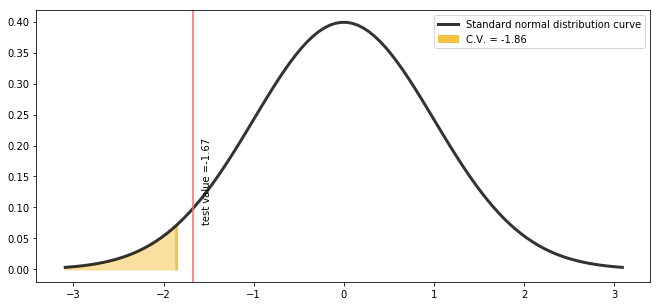


4. Result and decision (traditional method)
The decision is to not reject the null hypothesis.
There is not enough evidence to support the claim that μD is less than 0 with a significance level of 0.05.

Although the difference between sample mean and population mean is not significant, there is a risk of a type II error (not rejecting H0 althought it is false).
You could try to increase the significance level to decrease the probability of a type II error. However, this would increase the probability of a type I error


In [55]:
# Sample of 9 local banks that shows deposits (in billions of USD) in 2015 and 2018.
# At alpha = 0.05, can it be concluded that average of deposits 2018 is greater than 2015?
# Hint: since we are interested to see if increase, the deposits in 2015 must be less than in 2018.
# Hence, difference between 2 means must be less than 0.
# u1 - u2 < 0 => uD < 0
# u1 = mean 2015 (e.g. 5)
# u2 = mean 2018 (e.g. 10)
# 5 - 10 < 0
# If we wanted to prove if is more in 2015, then opposite.

deposit_list_2015 = [11.42, 8.41, 3.98, 7.37, 2.28, 1.10, 1.00, 0.9, 1.35]
deposit_list_2018 = [16.69, 9.44, 6.53, 5.58, 2.92, 1.88, 1.78, 1.5, 1.22]

compute_difference_between_two_means_dependent(
    dataset1=deposit_list_2015,    
    dataset2=deposit_list_2018,    
    expected_value=0,
    tail='left-tailed',
    significance_level=.05,
    ddof=1, # delta degree of freedome (default is 1)
    show_chart=True,
)

Parameters and statistics
-------------------------
Sample mean 1 (X1) = 209.83333333333334
Sample STD 1 = 26.940056916544677
Sample size 1 = 6
Sample mean 2 (X2) = 193.16666666666666
Sample STD 2 = 22.25683415642635
Sample size 2 = 6
Significance level = 0.1
Test type = two-tailed

1. Hypothesis
H0: μD = 0
H1: μD ≠ 0 (claim)

2. Critical value(s)
C.V. = ±2.02 (two-tailed)

3. Test value and chart
Test type: special t test (for dependent samples)
D sum = 100
D mean = 16.666666666666668
D² sum = 4890
SD = 25.39028685672272
test value = 1.6078916034608288


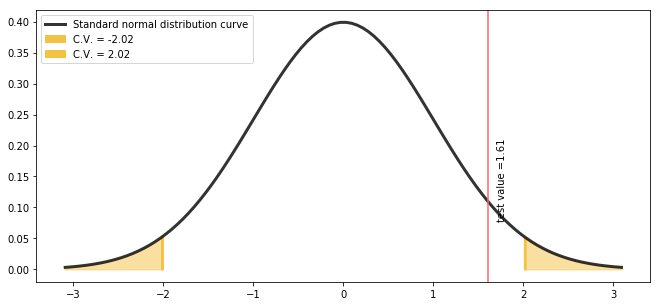


4. Result and decision (traditional method)
The decision is to not reject the null hypothesis.
There is not enough evidence to support the claim that μD is different from 0 with a significance level of 0.1.

Although the difference between sample mean and population mean is not significant, there is a risk of a type II error (not rejecting H0 althought it is false).
You could try to increase the significance level to decrease the probability of a type II error. However, this would increase the probability of a type I error


In [56]:
# Did cholesterol level change at alpha = 0.1 for participants who were tested before
# and after 6 weeks program?

cholesterol_level_list_pre = [210, 235, 208, 190, 172, 244]
cholesterol_level_list_post = [190, 170, 210, 188, 173, 228]

compute_difference_between_two_means_dependent(
    dataset1=cholesterol_level_list_pre,    
    dataset2=cholesterol_level_list_post,    
    expected_value=0,
    tail='two-tailed',
    significance_level=.10,
    ddof=1, # delta degree of freedome (default is 1)
    show_chart=True,
)

### Confidence interval

In [59]:
# What is 90% confidence interval for cholesterol level datasets?

cholesterol_level_list_pre = [210, 235, 208, 190, 172, 244]
cholesterol_level_list_post = [190, 170, 210, 188, 173, 228]

ci = compute_confidence_interval_for_difference_between_two_means_dependent(
    dataset1=cholesterol_level_list_pre,    
    dataset2=cholesterol_level_list_post,    
    expected_value=0,
    confidence_level=0.90,
    ddof=1, # delta degree of freedome (default is 1)
)

Confidence interval: -4.22 < μ1-μ2 < 37.55
Expected value: 0
The confidence interval contains the expected value, therefore we do NOT reject H0.


# Testing the difference between two proportions

Here we use the **z test** to test the equality of two proportions.

## Assumptions
- Random samples
- Samples independent of one another
- For both samples np >= 5 and nq >= 5

## Applications

Examples:
- Is proportion of men exercising less than female exercising?
- Is there a difference in the percentage of students who own personal laptop and the percentage of non-students who own one?

## Formulas

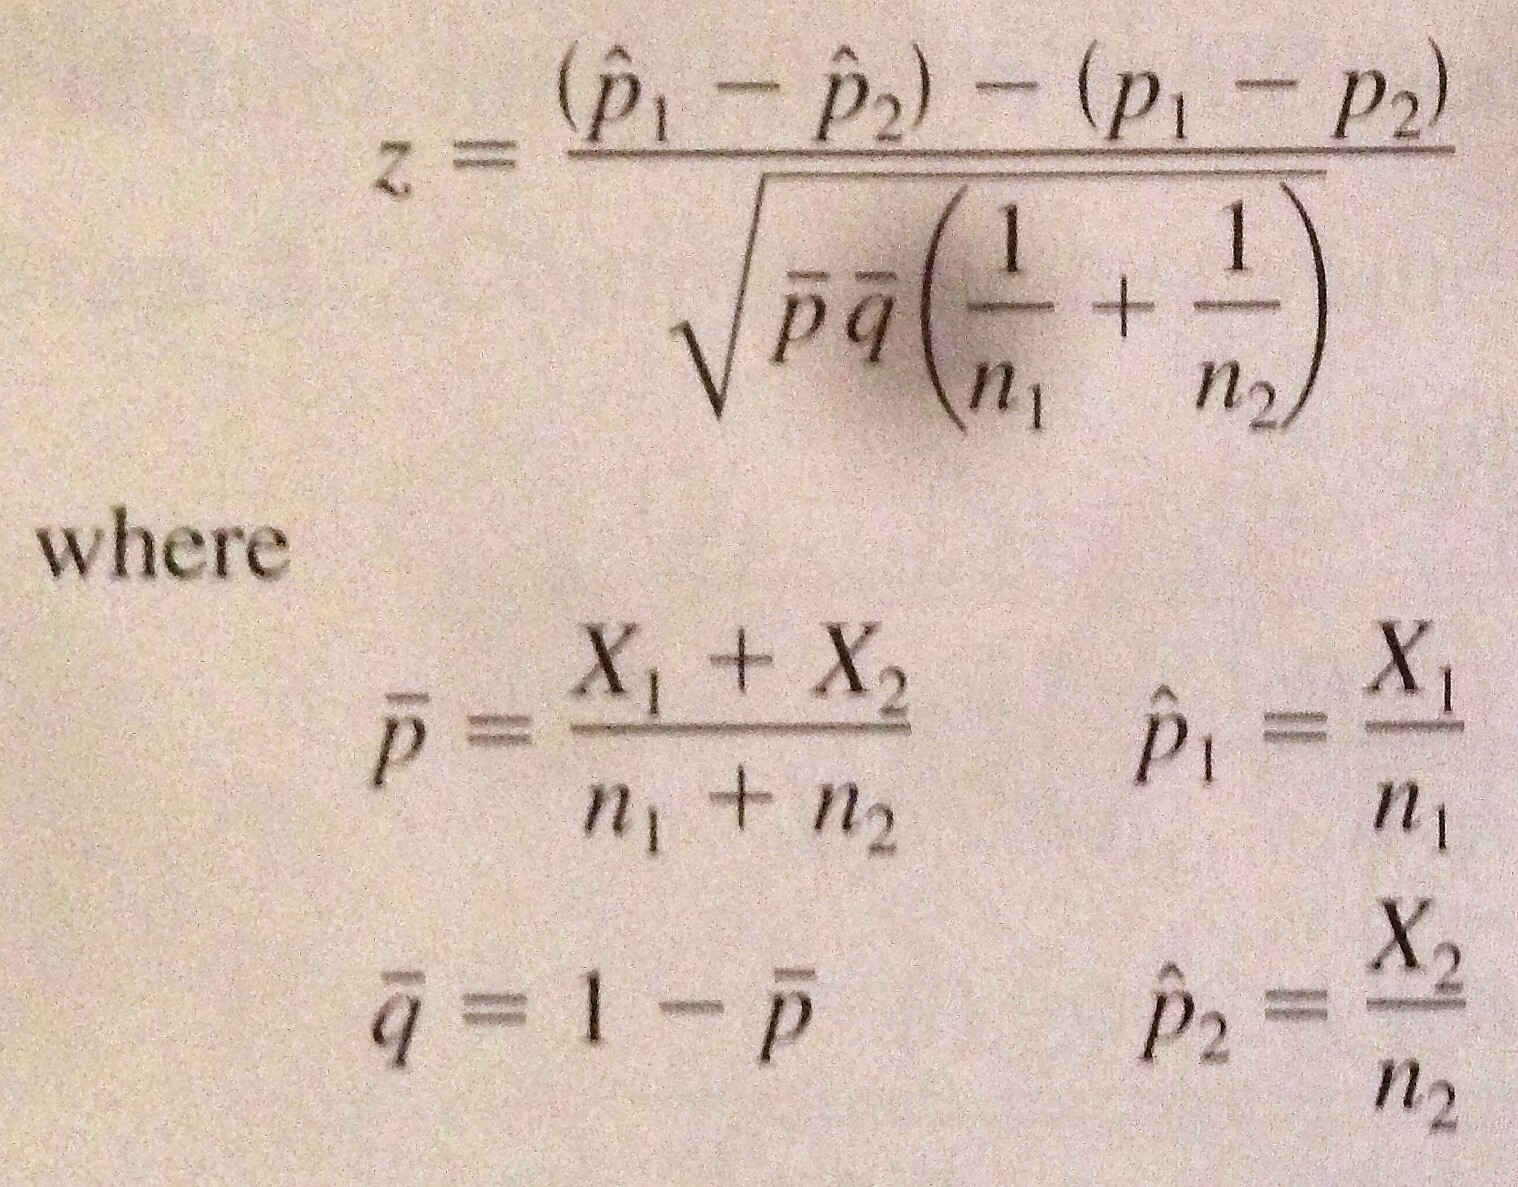

## Implementation

In [87]:
def compute_difference_between_two_proportions_independent(
    n1=None,
    X1=None,
    p_hat1=None,
    n2=None,
    X2=None,
    p_hat2=None,
    expected_value=0,
    tail='two-tailed',
    significance_level=.05,
    show_chart=False,
):
    r"""
    Conduct a statistical hypothesis test comparing two proportions of independent.
    The claim is the alternative hypothesis and the problem statement has to be formulated as such.
    """
    
    if p_hat1 and p_hat2:
        X1 = p_hat1*n1
        X2 = p_hat2*n2
    elif X1 and X2:  
        p_hat1 = X1/n1
        p_hat2 = X2/n2
        
    p_bar = (X1+X2)/(n1+n2)
    q_bar = 1-p_bar
    
    # Parameters and statistics
    print('Parameters and statistics')    
    print('-------------------------')
    print('p_hat1 =', p_hat1)
    print('p_hat2 =', p_hat2)
    print('p_bar =', p_bar)
    print('q_bar =', q_bar)
    print('alpha =', significance_level)
    print('Test type =', tail)
    
    # Conditions to stop
    assert tail in ('two-tailed', 'right-tailed', 'left-tailed')
    # assert n1*p1 >= 5 and n1*q1 >= 5
    # assert n2*p2 >= 5 and n2*q2 >= 5
    
    # 1. Hypothesis
    print()
    print('1. Hypothesis')
    if tail == 'two-tailed':
        operator = '≠'
        operator_label = 'different from'
    elif tail == 'right-tailed':
        operator = '>'
        operator_label = 'more than'
    elif tail == 'left-tailed':
        operator = '<'
        operator_label = 'less than'
    
    # Statement
    h0 = 'H0: p1 = p2'
    h1 = 'H1: p1 {} p2'.format(operator)
    print(h0, 'and', h1, '(claim)')
    
    # 2. Critical value(s)
    print()
    print('2. Critical value(s)')
    cv_left, cv_right = None, None
    tailed_alpha = significance_level
    
    if tail == 'two-tailed':
        tailed_alpha = significance_level/2
        cv_right = abs(get_zscore_from_probability(p_left=tailed_alpha))
        cv_left = -cv_right
        print('C.V. =', '±' + preferred_rounding(cv_right), '(two-tailed)')
    elif tail == 'right-tailed':
        cv_right= get_zscore_from_probability(p_right=tailed_alpha)
        print('C.V. =', preferred_rounding(cv_right), '(right-tailed)')
    elif tail == 'left-tailed':
        cv_left = get_zscore_from_probability(p_left=tailed_alpha)
        print('C.V. =', preferred_rounding(cv_left), '(left-tailed)')
            

    # 3. Test value and chart
    print()
    print('3. Test value and chart')
    
    # Hypothesis test for a proportion
    print('Test type: z test')

    standard_error = np.sqrt(p_bar*q_bar*(1/n1+1/n2))
    observed_value = p_hat1-p_hat2
    test_value = (observed_value-expected_value)/standard_error
    print('test value = ', preferred_rounding(test_value))
 
    # Chart
    if show_chart:
        display_probability_density_chart(
            cv_left=cv_left,
            cv_right=cv_right,
            test_value=test_value,
        )
        
    # 4. Result and decision (traditional method)
    print()
    print('4. Result and decision (traditional method)')
    
    decision_statement = 'reject'
    evidence_statement = 'enough evidence'
    if cv_left and cv_right:
        if (test_value < 0 and cv_left < test_value) or (test_value > 0 and cv_right > test_value):
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_left:
        if cv_left < test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_right:
        if cv_right > test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
            
    print('The decision is to', decision_statement, 'the null hypothesis.')
    
    claim = 'p1 is {} p2'.format(operator_label)
    print('There is', evidence_statement, 'to support the claim that', claim, 
          'with a significance level of', str(significance_level) + '.')
  
    print()
    if decision_statement == 'reject':
        print('Although the difference between the two sample proportions is said to be significant, there is a risk of a type I error',
              '(rejecting H0 althought it is true).')
        print('In this case, the probability of a type I error is', '{:0.0f}%'.format(significance_level*100) + '.')
        print('You could try to reduce the significance level to decrease the probability of a type I error.')
        
    elif decision_statement == 'not reject':
        print('Although the difference between the two sample proportions is not significant, there is a risk of a type II error',
              '(not rejecting H0 althought it is false).')
        print('You could try to increase the significance level to decrease the probability of a type II error.', 
              'However, this would increase the probability of a type I error')

## Examples

Parameters and statistics
-------------------------
p_hat1 = 0.35294117647058826
p_hat2 = 0.7083333333333334
p_bar = 0.5
q_bar = 0.5
alpha = 0.05
Test type = two-tailed

1. Hypothesis
H0: p1 = p2 and H1: p1 ≠ p2 (claim)

2. Critical value(s)
C.V. = ±1.96 (two-tailed)

3. Test value and chart
Test type: z test
test value =  -2.67


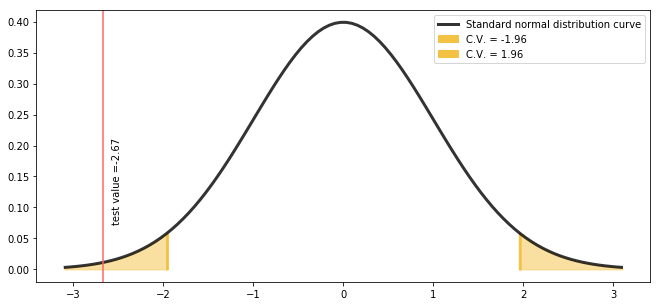


4. Result and decision (traditional method)
The decision is to reject the null hypothesis.
There is enough evidence to support the claim that p1 is different from p2 with a significance level of 0.05.

Although the difference between the two sample proportions is said to be significant, there is a risk of a type I error (rejecting H0 althought it is true).
In this case, the probability of a type I error is 5%.
You could try to reduce the significance level to decrease the probability of a type I error.


In [88]:
# Vaccination rates in nursing homes.
# 12 out of 34 small homes had a resident vaccination rate of less than 80%.
# 17 out of 24 large homes had a resident vaccination rate of less than 80%.
# At alpha = 0.05, test claim that there is difference between proportions.

compute_difference_between_two_proportions_independent(
    n1=34,
    X1=12,

    n2=24,
    X2=17,
   
    expected_value=0,
    tail='two-tailed',
    significance_level=.05,
    show_chart=True,
)

In [ ]:
# Survey of 1000 drivers in 2018 show that 29% of people send text messages while driving.
# Survey of 1000 drivers in 2017 show that 17% of people send text messages while driving.
# At alpha = 0.01, can we conclude that there is an increase in number of drivers who text?

Parameters and statistics
-------------------------
p_hat1 = 0.29
p_hat2 = 0.17
p_bar = 0.23
q_bar = 0.77
alpha = 0.01
Test type = right-tailed

1. Hypothesis
H0: p1 = p2 and H1: p1 > p2 (claim)

2. Critical value(s)
C.V. = 3.33 (right-tailed)

3. Test value and chart
Test type: z test
test value =  6.38


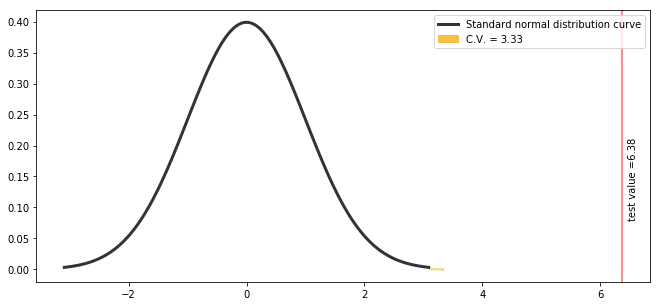


4. Result and decision (traditional method)
The decision is to reject the null hypothesis.
There is enough evidence to support the claim that p1 is more than p2 with a significance level of 0.01.

Although the difference between the two sample proportions is said to be significant, there is a risk of a type I error (rejecting H0 althought it is true).
In this case, the probability of a type I error is 1%.
You could try to reduce the significance level to decrease the probability of a type I error.


In [89]:
compute_difference_between_two_proportions_independent(
    n1=1000,
    p_hat1=.29,

    n2=1000,
    p_hat2=.17,
   
    expected_value=0,
    tail='right-tailed',
    significance_level=0.01,
    show_chart=True,
)

Parameters and statistics
-------------------------
p_hat1 = 0.323
p_hat2 = 0.145
p_bar = 0.234
q_bar = 0.766
alpha = 0.05
Test type = two-tailed

1. Hypothesis
H0: p1 = p2 and H1: p1 ≠ p2 (claim)

2. Critical value(s)
C.V. = ±1.96 (two-tailed)

3. Test value and chart
Test type: z test
test value =  9.4


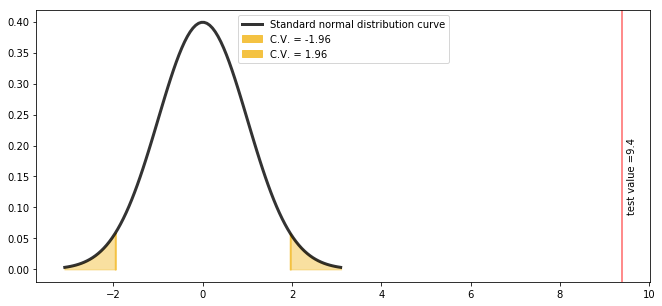


4. Result and decision (traditional method)
The decision is to reject the null hypothesis.
There is enough evidence to support the claim that p1 is different from p2 with a significance level of 0.05.

Although the difference between the two sample proportions is said to be significant, there is a risk of a type I error (rejecting H0 althought it is true).
In this case, the probability of a type I error is 5%.
You could try to reduce the significance level to decrease the probability of a type I error.


In [90]:
# Smokers public school = 32.3% with n = 1000.
# Smokers private school = 14.5% with n = 1000.
# Alpha = 0.05.
# Want to conclude there is no difference (that we don't reject H0).

compute_difference_between_two_proportions_independent(
    n1=1000,
    p_hat1=.323,

    n2=1000,
    p_hat2=.145,
   
    expected_value=0,
    tail='two-tailed',
    significance_level=0.05,
    show_chart=True,
)

# Testing the difference between two variances and standard deviations

For the comparison we use the **F test**. This is different from chi-square test as we are comparing samples here and not sample to population!

**Note that we would always get the same hypothesis test result for variance and STD!**

Note that the **F-test is extremely sensitive to non-normality of sample datasets**, hence it is often better to do a more robust test such as **Levene's test** or **Bartlett's test**.

## Applications
Examples:
- Is the variation in the temperature of a certain month different in two cities?
- Compare variance of cholesterol of men to variance of cholesterol of women.

## F distribution

F distribution is the sampling distribution of the variances of two independent samples selected from normally distributed populations in which the variances are equal.

**Characteristics:**
- Values of F cannot be negative, because variances >= 0
- Distribution positively skewed
- Mean value of F approximatively equal to 1
- F distribution is a family of curves based on the degrees of freedom of the variance of the numerator and the degrees of freedom of teh variance of the denominator.

## Formulas

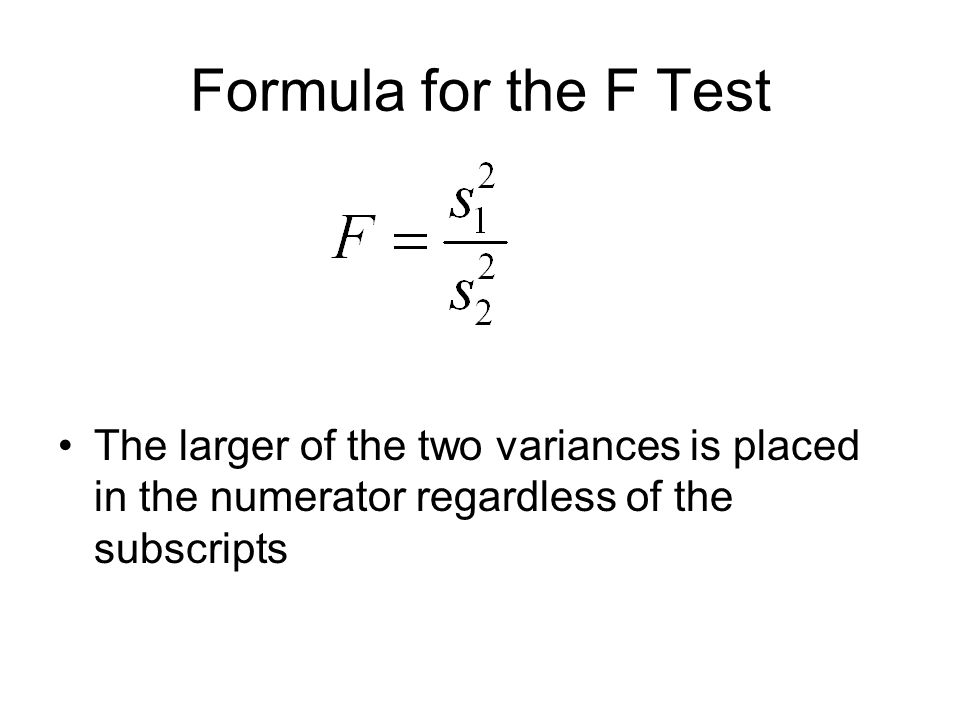

## Implementation

In [107]:
def compute_f_test(
    nn=None, # sample size from which numerator was obtained
    nd=None, # sample size from which denominator was obtained
    dfn=None,
    dfd=None,
    alpha=0.05,
    tail='two-tailed',
    ddof=1,
):
    # Conditions
    assert tail in ('two-tailed', 'right-tailed', 'left-tailed')
    
    if nn and nd:
        dfn = nn-ddof
        dfd = nd-ddof
    
    # For F test we place the critical value on the right side of the F curve (no left side)
    if tail == 'two-tailed':
        alpha_half = alpha / 2
        f_test_right = stats.f.ppf(1-alpha_half, dfn, dfd)
        return f_test_right
    
    elif tail == 'right-tailed':
        return stats.f.ppf(1-alpha, dfn, dfd)
        
    elif tail == 'left-tailed':
        return stats.f.ppf(alpha, dfn, dfd)

In [97]:
compute_f_test(
    dfn=15,
    dfd=21,
    alpha=0.05,
    tail='two-tailed',
)

2.175669572571705

In [108]:
compute_f_test(
    nn=21, # sample size from which numerator was obtained
    nd=12, # sample size from which denominator was obtained
    alpha=0.05,
    tail='two-tailed',
)

3.226144774964769

In [154]:
def compute_hypothesis_test_for_consistency_sample(
    dataset1=None,
    n1=None,
    sample_variance1=None,
    sample_std1=None,
    
    dataset2=None,
    n2=None,
    sample_variance2=None,
    sample_std2=None,
    
    statistic_measure='variance',
    tail='two-tailed',
    significance_level=.05,
    ddof = 1,
):
    r"""
    Conduct a statistical hypothesis test comparing a difference between two variances and STD. 
    The claim is the alternative hypothesis and the problem statement has to be formulated as such.
    """ 
    
    if dataset1 and dataset2:
        dataset_np1 = np.array(dataset1)
        n1 = len(dataset_np1) # sample size
        sample_variance1 = np.var(dataset_np1, ddof=ddof)
        sample_std1 = np.std(dataset_np1, ddof=ddof)
        
        dataset_np2 = np.array(dataset2)
        n2 = len(dataset_np2) # sample size
        sample_variance2 = np.var(dataset_np2, ddof=ddof)
        sample_std2 = np.std(dataset_np2, ddof=ddof)
        
    if sample_std1 and sample_std2:
        sample_variance1 = np.power(sample_std1, 2)
        sample_variance2 = np.power(sample_std2, 2)
        
    dfn = max([n1, n2])-ddof
    dfd = min([n1, n2])-ddof
        
    # Conditions to stop
    assert tail in ('two-tailed', 'right-tailed', 'left-tailed')
    assert statistic_measure in ('variance', 'standard deviation')
        
    if statistic_measure == 'variance':
        statistic_symbol = 'σ²'
        statistic_label = 'variance'
    else:
        statistic_symbol = 'σ'
        statistic_label = 'standard deviation'

    
    # Parameters and statistics
    print('Parameters and statistics')    
    print('-------------------------')
    print('d.f.N. =', dfn)
    print('d.f.D. =', dfd)
    print('sample variance 1 (s²) =', sample_variance1)
    print('sample standard deviation 1 (s) =', sample_std1)
    print('sample variance 2 (s²) =', sample_variance2)
    print('sample standard deviation 2 (s) =', sample_std2)
    print('alpha =', significance_level)
    print('test type =', tail)
    
    
    # 1. Hypothesis
    print()
    print('1. Hypothesis')
    sample_supports_claim = False
    if tail == 'two-tailed':
        operator = '≠'
        operator_label = 'different from'
    elif tail == 'right-tailed':
        operator = '>'
        operator_label = 'more than'
    elif tail == 'left-tailed':
        operator = '<'
        operator_label = 'less than'
    
    # Statement
    h0 = 'H0: {statistic_symbol}1 = {statistic_symbol}2'.format(statistic_symbol=statistic_symbol)
    h1 = 'H1: {statistic_symbol}1 {operator} {statistic_symbol}2'.format(statistic_symbol=statistic_symbol, operator=operator)
    print(h0, 'and', h1, '(claim)')
    
    # 2. Critical value(s)
    print()
    print('2. Critical value(s)')
    cv_left, cv_right = None, None

    tailed_alpha = significance_level
    if tail == 'two-tailed':
        cv_right = compute_f_test(
            dfn=dfn,
            dfd=dfd,
            alpha=significance_level,
            tail='two-tailed',
        )
        print('C.V. right =', preferred_rounding(cv_right), '(two-tailed)')
        tailed_alpha = significance_level/2
    elif tail == 'right-tailed':
        cv_right = compute_f_test(
            dfn=dfn,
            dfd=dfd,
            alpha=significance_level,
            tail='right-tailed',
        )
        print('C.V. =', preferred_rounding(cv_right), '(right-tailed)')
    elif tail == 'left-tailed':
        cv_left = compute_f_test(
            dfn=dfn,
            dfd=dfd,
            alpha=significance_level,
            tail='left-tailed',
        )
        print('C.V. =', preferred_rounding(cv_left), '(left-tailed)')
            

    # 3. Test value
    print()
    print('3. Test value')
    
    # Hypothesis test for a variance or 
    print('Test type: F test')

    # test value
    test_value = max([sample_variance1, sample_variance2])/min([sample_variance1, sample_variance2])
    
    # P-value
    p_value = stats.f.cdf(test_value, dfn, dfd)
    if p_value >= .5:
        p_value = 1 - stats.f.cdf(test_value, dfn, dfd)
    if tail == 'two-tailed':      
        p_value = p_value*2
        
    print('test value = ', preferred_rounding(test_value))
    print('P-value =', preferred_rounding(p_value, 4))
        
        
    # 4a. Result and decision (traditional method)
    print()
    print('4a. Result and decision (traditional method)')
    
    decision_statement = 'reject'
    evidence_statement = 'enough evidence'
    if cv_left and cv_right:
        if (test_value < 0 and cv_left < test_value) or (test_value > 0 and cv_right > test_value):
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_left:
        if cv_left < test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
    elif cv_right:
        if cv_right > test_value:
            decision_statement = 'not reject'
            evidence_statement = 'not enough evidence'
            
    print('The decision is to', decision_statement, 'the null hypothesis.')
    
    claim = '{statistic_label}1 is {operator_label} {statistic_label}2'.format(statistic_label=statistic_label, operator_label=operator_label)
    print('There is', evidence_statement, 'to support the claim that', claim, 
          'with a significance level of', str(significance_level) + '.')
  
    print()
    if decision_statement == 'reject':
        print('Although the difference between {} of sample1 and sample2 is said to be significant, there is a risk of a type I error (rejecting H0 althought it is true).'.format(statistic_measure))
        print('In this case, the probability of a type I error is', '{:0.0f}%'.format(significance_level*100) + '.')
        print('You could try to reduce the significance level to decrease the probability of a type I error.')
        
    elif decision_statement == 'not reject':
        print('Although the difference between sample {} and population {} is not significant, there is a risk of a type II error (not rejecting H0 althought it is false).'.format(statistic_label, statistic_label))
        print('You could try to increase the significance level to decrease the probability of a type II error. However, this would increase the probability of a type I error')
        
        
    # 4b. Result and decision (P-value method)
    print()
    print('4b. Result and decision (P-value method)')
    if p_value <= tailed_alpha:
        decision_statement_p_value_method = 'reject'
        print('P-value ≤ ∝, therefore we reject H0.')
    else:
        decision_statement_p_value_method = 'not reject'
        print('P-value > ∝, therefore we do NOT reject H0.')  
        
    # 5. Summary
    print()
    print('5. Summary')
    if decision_statement == decision_statement_p_value_method:
        print('The traditional method and P-value method support the same conclusion.')
    else:
        print('The traditional method and P-value method do NOT support the same conclusion.')

In [155]:
# Compare variance of heart rates (BPM) of smokers and non-smokers.
# Smoker sample: n1=26, s²1=36
# Non-smoker sample: n2=18, s²2=10
# Test with alpha = 0.05 whether there is difference.

# C.V. is suppose to be 3.31
compute_hypothesis_test_for_consistency_sample(
    dataset1=None,
    n1=26,
    sample_variance1=36,
    sample_std1=None,
    
    dataset2=None,
    n2=18,
    sample_variance2=10,
    sample_std2=None,
    
    statistic_measure='variance',
    tail='two-tailed',
    significance_level=.05,
    ddof = 1,
)

Parameters and statistics
-------------------------
d.f.N. = 25
d.f.D. = 17
sample variance 1 (s²) = 36
sample standard deviation 1 (s) = None
sample variance 2 (s²) = 10
sample standard deviation 2 (s) = None
alpha = 0.05
test type = two-tailed

1. Hypothesis
H0: σ²1 = σ²2 and H1: σ²1 ≠ σ²2 (claim)

2. Critical value(s)
C.V. right = 2.55 (two-tailed)

3. Test value
Test type: F test
test value =  3.6
P-value = 0.0084

4a. Result and decision (traditional method)
The decision is to reject the null hypothesis.
There is enough evidence to support the claim that variance1 is different from variance2 with a significance level of 0.05.

Although the difference between variance of sample1 and sample2 is said to be significant, there is a risk of a type I error (rejecting H0 althought it is true).
In this case, the probability of a type I error is 5%.
You could try to reduce the significance level to decrease the probability of a type I error.

4b. Result and decision (P-value method)
P-value

In [156]:
# STD of average waiting time to see doctor at hospital A is 32 min. Sample of 16 patients.
# STD of average waiting time to see doctor at hospital B is 28 min. Sample of 18 patients.
# Enough evidence to conclude at 0.01 significance level that STD of hospital A is greater
# than at hospital B? 

compute_hypothesis_test_for_consistency_sample(
    dataset1=None,
    n1=16,
    sample_variance1=None,
    sample_std1=32,
    
    dataset2=None,
    n2=18,
    sample_variance2=None,
    sample_std2=28,
    
    statistic_measure='standard deviation',
    tail='right-tailed',
    significance_level=.01,
    ddof = 1,
)

Parameters and statistics
-------------------------
d.f.N. = 17
d.f.D. = 15
sample variance 1 (s²) = 1024
sample standard deviation 1 (s) = 32
sample variance 2 (s²) = 784
sample standard deviation 2 (s) = 28
alpha = 0.01
test type = right-tailed

1. Hypothesis
H0: σ1 = σ2 and H1: σ1 > σ2 (claim)

2. Critical value(s)
C.V. = 3.45 (right-tailed)

3. Test value
Test type: F test
test value =  1.31
P-value = 0.3043

4a. Result and decision (traditional method)
The decision is to not reject the null hypothesis.
There is not enough evidence to support the claim that standard deviation1 is more than standard deviation2 with a significance level of 0.01.

Although the difference between sample standard deviation and population standard deviation is not significant, there is a risk of a type II error (not rejecting H0 althought it is false).
You could try to increase the significance level to decrease the probability of a type II error. However, this would increase the probability of a type I 

In [157]:
# Is variance US airport passengers count > variance foreign airport passenger count?
# Use alpha = 0.10

us_airport_passenger_list = [36.8, 72.4, 60.5, 73.5, 61.2, 40.1]
intl_airport_passenger_list = [60.7, 51.2, 42.7, 38.6]

compute_hypothesis_test_for_consistency_sample(
    dataset1=us_airport_passenger_list,
    dataset2=intl_airport_passenger_list,    
    statistic_measure='variance',
    tail='right-tailed',
    significance_level=.10,
    ddof = 1,
)

Parameters and statistics
-------------------------
d.f.N. = 5
d.f.D. = 3
sample variance 1 (s²) = 246.3816666666667
sample standard deviation 1 (s) = 15.696549514675723
sample variance 2 (s²) = 95.87333333333333
sample standard deviation 2 (s) = 9.791492906259665
alpha = 0.1
test type = right-tailed

1. Hypothesis
H0: σ²1 = σ²2 and H1: σ²1 > σ²2 (claim)

2. Critical value(s)
C.V. = 5.31 (right-tailed)

3. Test value
Test type: F test
test value =  2.57
P-value = 0.2336

4a. Result and decision (traditional method)
The decision is to not reject the null hypothesis.
There is not enough evidence to support the claim that variance1 is more than variance2 with a significance level of 0.1.

Although the difference between sample variance and population variance is not significant, there is a risk of a type II error (not rejecting H0 althought it is false).
You could try to increase the significance level to decrease the probability of a type II error. However, this would increase the probab

In [158]:
# Which country has greatest variability in transmission price?
# Use alpha = 0.10 and 0.01

jp_price_list = [1940, 1810, 1871, 1822, 1920, 1730]
us_price_list = [2363, 1230, 1332, 932, 1790, 1833]

compute_hypothesis_test_for_consistency_sample(
    dataset1=jp_price_list,
    dataset2=us_price_list,    
    statistic_measure='variance',
    tail='two-tailed',
    significance_level=.10,
    ddof = 1,
)

Parameters and statistics
-------------------------
d.f.N. = 5
d.f.D. = 5
sample variance 1 (s²) = 6043.366666666667
sample standard deviation 1 (s) = 77.73909355444445
sample variance 2 (s²) = 265021.2
sample standard deviation 2 (s) = 514.8020978978233
alpha = 0.1
test type = two-tailed

1. Hypothesis
H0: σ²1 = σ²2 and H1: σ²1 ≠ σ²2 (claim)

2. Critical value(s)
C.V. right = 5.05 (two-tailed)

3. Test value
Test type: F test
test value =  43.85
P-value = 0.0008

4a. Result and decision (traditional method)
The decision is to reject the null hypothesis.
There is enough evidence to support the claim that variance1 is different from variance2 with a significance level of 0.1.

Although the difference between variance of sample1 and sample2 is said to be significant, there is a risk of a type I error (rejecting H0 althought it is true).
In this case, the probability of a type I error is 10%.
You could try to reduce the significance level to decrease the probability of a type I error.

4b